In [1]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]
def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

def read_file(file_name):
    """
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            data.append([a, b, float(dist)])
    return data

def write_file(file_name, data):
    with open(file_name, 'w') as out:
        for a,b,dist in data:
            out.write(a +'\t'+ b +'\t'+str(dist) +'\n')
            
def write_sol(file_name, pos):
    pos = sorted(pos.items(), key = lambda x: x[1])
    with open(file_name, 'w') as out:
        for contig, position in pos:
            out.write(contig +'\t'+ str(position) + '\n')
            
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
            
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)

    return position, contig_repeat
            
def sortiere_repeats(position, contig_repeat):
    
    for contig,repeats in contig_repeat.items():
        if len(repeats) == 1:
            continue
        
        for rep, pos in zip(repeats, sorted([position[rep] for rep in repeats])):
            position[rep] = pos
            
def get_contigs(data):
    contigs = set()
    for a, b, _, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
#connected('my_apd200.lst')


def solve_LP(position, graph, folgende):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(folgende)
    
    contig.update(position)
  #  model.update()
        
    # Bedingungen
    fehler = []
    for a, b, dist in graph.edges:
        eps = model.addVar()
       # faktor = (1000 + dist)/33942.74
        model.addConstr( contig[b] - contig[a] - dist <= eps ) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps ) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    #model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in folgende}


def entferne_sackgassen(graph, start = '2345APD_0', ziel = '2080APD_0'):
    änderungen = True
    while änderungen:
        änderungen = False
        for x in list(graph):
            if graph.in_degree[x] == 0 and x != start:
                graph.remove_node(x)
                änderungen = True
            elif graph.out_degree[x] == 0 and x != ziel:
                graph.remove_node(x)
                änderungen = True
def get_intName(position):

    pos = sorted([(value, key) for key, value in position.items()])
    
    intName = {k: i for i, (v, k) in enumerate(pos)}
    intName.update({i: k for i, (v, k) in enumerate(pos)})
    
    return intName


def sub(al, bl, dist, tol = 1000):
    k = iter(bl)
    for i in al:
        i += dist
        try:
            e = next(k)
            while e < i - tol:
                e = next(k)
            if e > i + tol:
                return True
        except:
            return True
    return False

def b_dom_a(aneig,bneig,abdist):
    for c, la in aneig.items():
        if sub(la, bneig[c],abdist):
            return False
    return True

def überdeckte(graph):
    neigh = {}
    for b in graph:
        neigh[b] = coll.defaultdict(list)
        for a, l in graph.pred[b].items():
            neigh[b][a] = sorted([-d for d in l])
        neigh[b][b].append(0)
        for c, l in graph.succ[b].items():
            neigh[b][c] += sorted([d for d in l])
        neigh[b] = dict(neigh[b])
        
        
    evil = set()
    
    for a, aneig in neigh.items():
        for b, l in aneig.items():
            
            if len(l) > 1 or a == b:
                continue
                
            bneig = neigh[b]
            if not set(aneig) <= set(bneig):
                continue
                
            abdist = l[0]
            if b_dom_a(aneig,bneig,abdist):
                evil.add(a)
    return evil


def mehrfach(adj):
    for b,l in adj.items():
        if len(l) > 1:
            return True
    return False

def singels(graph):
    evil = []
    for a in graph:
        if mehrfach(graph.succ[a]) or mehrfach(graph.pred[a]):
            continue
        evil.append(a)
    return evil


In [2]:
def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    abstand = min_abstand
    for current in sorted_werte:
        if current - previous > abstand:
            abstand = min_abstand
            groups.append([np.mean(current_group), len(current_group)])
            current_group = []
    #    elif current - previous > abstand:
     #       abstand = current - previous
        current_group.append(current)
        previous = current
    groups.append([np.mean(current_group), len(current_group)])
    return groups


data2 = read_file('my_apd199.lst')
data2 = connected(data2)
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    else:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('anzahl aller constraints:  %6d'%sum(len(z[x]) for x in z))
print('anzahl aller Gruppen:      %6d'%sum(len(Z[x]) for x in Z))
print('Anzahl aller Contig Paare: %6d'%len(Z))
print('Anzahl aller Dopplungen:   %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))


data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g

#data4 = [[a,b,d] for d,a,b,g in data3 if g>0]
#len(data3),len(data4)
data4 = [[a,b,d] for d,a,b,g in data3 if a != b]

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
anzahl aller constraints:  122219
anzahl aller Gruppen:       55642
Anzahl aller Contig Paare:  49415
Anzahl aller Dopplungen:     6227


In [21]:
T = {a:set() for x in Z for a in x}

In [22]:
for a,b in Z:
    T[a].add(b)
    T[b].add(a)

In [23]:
for a in T:
    T[a] = len(T[a])

In [24]:
sum(T.values())/len(T)

46.502593116454506

In [13]:
max(T.values())

160

In [3]:
data4 = []
for d,a,b,g in data3:
    if g > 1:
        data4.append((a,b,d,g-1))
    else:
        data4.append((a,b,d,-2))

In [201]:
model = Model()

edges = model.addVars(data4[:5], GRB.INTEGER)

In [202]:
edges

{('1001APD_0', '1001APD_0', 28483.0, -2, 'I'): <gurobi.Var C0>,
 ('1001APD_0', '100APD_0', 53815.0, -2, 'I'): <gurobi.Var C1>,
 ('1001APD_0', '1046APD_0', 151293.0, -2, 'I'): <gurobi.Var C2>,
 ('1001APD_0', '10APD_0', 14420.777777777777, 8, 'I'): <gurobi.Var C3>,
 ('1001APD_0', '1130APD_0', 126367.0, -2, 'I'): <gurobi.Var C4>}

In [203]:
sum((d*v for (a,b,d,g,_),v in edges.items())) <= 100

<gurobi.TempConstr: <gurobi.LinExpr: 28483.0 C0 + 53815.0 C1 + 151293.0 C2 + 14420.777777777777 C3 + 126367.0 C4> <= 100>

In [4]:
graph = nx.DiGraph()

In [28]:
def ilp_am_pfadigsten(data):
    start = '2345APD_0'
    ziel = '2080APD_0'

    graph = nx.DiGraph()
    for a,b,_ in data:
        if a != b:
            graph.add_edge(a,b)
    entferne_sackgassen(graph)
    
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    
    edges = model.addVars(graph.edges(), vtype = GRB.INTEGER)
    
    nodes = model.addVars(graph, vtype = GRB.BINARY)
    
    for c in graph:
        if c == start:
            continue
        if c == ziel:
            continue
        if graph.out_degree(c) > graph.in_degree(c):
            model.addConstr( sum(edges[a,c] for a in graph.predecessors(c)) >= 1 - nodes[c] )
        else:
            model.addConstr( sum(edges[c,b] for b in graph.successors(c)) >= 1 - nodes[c] )
            
    for c in graph:
        if c == start:
            model.addConstr(
                sum(edges[c,b] for b in graph.successors(c)) == 
                sum(edges[a,c] for a in graph.predecessors(c)) + 1
            )
            continue
        if c == ziel:
            model.addConstr(
                sum(edges[c,b] for b in graph.successors(c)) + 1 == 
                sum(edges[a,c] for a in graph.predecessors(c)) 
            )
            continue
        model.addConstr(
            sum(edges[c,b] for b in graph.successors(c)) == 
            sum(edges[a,c] for a in graph.predecessors(c)) 
        )
        
    model.update()
    model.setObjective(sum(edges.values()) + 20 * sum(nodes.values()), GRB.MINIMIZE)
    
    while True:
        model.update()
        model.optimize()

        graphX = nx.MultiDiGraph()
      #  print(sum(edges[c,b].X for b in graph.successors(c)), sum(edges[a,c].X for a in graph.predecessors(c)) + 1)
    #    for e,v in edges.items():

     #       if v.X != 0 and v.X != 1:
      #          print(v.X)
        graphX.add_edges_from(e for e,v in edges.items() for i in range(int(v.X)))
        comp = list(nx.weakly_connected_components(graphX))
        print(len(comp),model.objVal)
        if len(comp) == 1:
            return graphX
        for x in nx.weakly_connected_components(graphX):
            if '2345APD_0' in x:
                continue
            preds = [ 
                (a,c) 
                for c in x 
                for a in graph.predecessors(c) if not a in x
            ]
            succs = [ 
                (c,b) 
                for c in x 
                for b in graph.successors(c) if not b in x
            ]
            X = min([succs,preds], key = len)
            model.addConstr( sum(edges[e] for e in X) >= 1 )
    return graphX

In [86]:
def ilp_noch_pfadiger(graph):
    start = '2345APD_0'
    ziel = '2080APD_0'
    """
    graph = nx.DiGraph()
    for a,b,_ in data:
        if a != b:
            graph.add_edge(a,b)
            
            
    na = set(nx.shortest_path(graph, start))
    nb = set(nx.shortest_path(graph, target = ziel))
    graph = graph.subgraph(na&nb)
    #entferne_sackgassen(graph)
    """
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    edges = model.addVars(graph.edges(), vtype = GRB.INTEGER)
    edges_jn = model.addVars(graph.edges(), vtype = GRB.BINARY)
    #"""  
    nodes = model.addVars(graph, vtype = GRB.BINARY)
    for e in graph.edges():
        model.addConstr( edges[e]  <= 100000*edges_jn[e] )
    for c in graph:
        if c == start:
            continue
        if c == ziel:
            continue
        if graph.out_degree(c) > graph.in_degree(c):
            model.addConstr( sum(edges[a,c] for a in graph.predecessors(c)) >= 10000 - 10000*nodes[c] )
            model.addConstr( sum(edges[a,c] for a in graph.predecessors(c)) <= 100000 - 100000*nodes[c] )
        else:
            model.addConstr( sum(edges[c,b] for b in graph.successors(c)) >= 10000 - 10000*nodes[c] )
            model.addConstr( sum(edges[c,b] for b in graph.successors(c)) <= 100000 - 100000*nodes[c] )
    #"""    
    for c in graph:
        if c == start:
            model.addConstr(
                sum(edges[c,b] for b in graph.successors(c)) == 10000
            )
            continue
        if c == ziel:
            continue
        model.addConstr(
            sum(edges[c,b] for b in graph.successors(c)) == 
            sum(edges[a,c] for a in graph.predecessors(c)) + 1 - nodes[c]
        )
        
    model.update()
    model.setObjective(2*sum(edges[a,ziel] for a in graph.predecessors(ziel)) - sum(edges_jn.values()), GRB.MAXIMIZE)
    
    model.update()
    model.optimize()
    
    graphX = nx.DiGraph()
    for (a,b),v in edges.items():
        if v.X > 0:
            graphX.add_edge(a,b,gewicht = v.X)
    
    evil = [c for c, v in nodes.items() if v.X > 0]
    return graphX, evil

In [3]:
data4 = [[a,b,d,g] for d,a,b,g in data3 if a != b]
graph = nx.MultiDiGraph()
for a,b,d,g in data4:
    if a != b:
        graph.add_edge(a,b,d,gewicht = g)

start = '2345APD_0'
ziel = '2080APD_0'
na = set(nx.shortest_path(graph, start))
nb = set(nx.shortest_path(graph, target = ziel))
graph = graph.subgraph(na&nb)



In [4]:
def ist_nicht_verkürzbar(graph,a,b,d,g):
    for c in set(graph.successors(a)) & set(graph.predecessors(b)):
        for (d1, g1), (d2, g2) in it.product(graph[a][c].items(),graph[c][b].items()):
            g1 = g1['gewicht']
            g2 = g2['gewicht']
            if -1000 <= d1 + d2 - d <= 1000 and g <= g1 and g <= g2:
                return False
    return True
graph2 = nx.MultiDiGraph()
for a,b,d,g in graph.edges(keys = True, data = 'gewicht'):
    if ist_nicht_verkürzbar(graph,a,b,d,g):
        graph2.add_edge(a,b,d,gewicht = g)

graph3 = nx.DiGraph()
for a in graph2:
    for b, D in graph2.succ[a].items():
        g, d = max((D[d]['gewicht'],d) for d in D)
        graph3.add_edge(a,b,gewicht = g)

In [ ]:
graph3 = nx.MultiDiGraph()
for a,b,d,g in graph2.edges(keys = True, data = 'gewicht'):
    if ist_nicht_verkürzbar(graph,a,b,d,g):
        graph2.add_edge(a,b,d,gewicht = g)

In [10]:
curr = start
for a in nx.bfs_edges(graph2, start,300):
    print(a)

('2345APD_0', '431APD_0')
('431APD_0', '1836APD_0')
('1836APD_0', '368APD_0')
('368APD_0', '1079APD_0')
('368APD_0', '126APD_0')
('1079APD_0', '1146APD_0')
('1079APD_0', '528APD_0')
('528APD_0', '227APD_0')
('227APD_0', '193APD_0')
('227APD_0', '1636APD_0')
('193APD_0', '1767APD_0')
('1767APD_0', '524APD_0')
('524APD_0', '1938APD_0')
('1938APD_0', '1671APD_0')
('1938APD_0', '2406APD_0')
('2406APD_0', '556APD_0')
('556APD_0', '1538APD_0')
('1538APD_0', '774APD_0')
('1538APD_0', '873APD_0')
('873APD_0', '1262APD_0')
('873APD_0', '1280APD_0')
('873APD_0', '475APD_0')
('873APD_0', '128APD_0')
('873APD_0', '1387APD_0')
('1262APD_0', '2230APD_0')
('1262APD_0', '436APD_0')
('1280APD_0', '602APD_0')
('602APD_0', '1122APD_0')
('1122APD_0', '2131APD_0')
('2131APD_0', '1965APD_0')
('2131APD_0', '438APD_0')
('1965APD_0', '2040APD_0')
('2040APD_0', '2279APD_0')
('2279APD_0', '1655APD_0')
('1655APD_0', '809APD_0')
('809APD_0', '950APD_0')
('950APD_0', '1247APD_0')
('1247APD_0', '1975APD_0')
('1975AP

In [6]:
len([a for a in graph2 if graph2.in_degree(a) > 1 or graph2.out_degree(a) > 1 ])

1011

In [7]:
len([a for a in graph2 if graph2.in_degree(a) == graph2.out_degree(a) == 1 ])

1055

In [97]:
graph, evil = ilp_noch_pfadiger(graph3)


Optimize a model with 9168 rows, 8011 columns and 23017 nonzeros
Variable types: 0 continuous, 8011 integer (5039 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 1111 rows and 1673 columns
Presolve time: 0.58s
Presolved: 8057 rows, 6338 columns, 21192 nonzeros
Variable types: 0 continuous, 6338 integer (3864 binary)

Root relaxation: objective 2.385688e+04, 11148 iterations, 2.14 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 23856.8766    0 3363          - 23856.8766      -     -    3s
     0     0 22679.8927    0 3303          - 22679.8927      -     -    4s
     0     0 22091.2168    0 1871          - 22091.2168      -     -    5s
     0     0 22041.2289    0 1049          - 22041.2289      -     -    5s
     0     0 22035.3

In [98]:
len(graph.edges())

2046

In [99]:
evil

['2090APD_0',
 '2374APD_0',
 '2414APD_0',
 '520APD_0',
 '1431APD_0',
 '2213APD_0',
 '1806APD_0',
 '383APD_0',
 '1554APD_0',
 '1858APD_0',
 '1034APD_0',
 '2393APD_0',
 '2229APD_0',
 '591APD_0',
 '1736APD_0',
 '651APD_0',
 '2100APD_0',
 '1065APD_0',
 '387APD_0',
 '2025APD_0',
 '2008APD_0',
 '199APD_0',
 '1244APD_0',
 '685APD_0',
 '1438APD_0',
 '961APD_0',
 '2164APD_0',
 '2400APD_0',
 '1906APD_0']

In [66]:
graph.out_edges(s,data = 'gewicht')

OutEdgeDataView([('1483APD_0', '546APD_0', 10001.0)])

In [100]:
for a,b,e in graph.edges(data = 'gewicht'):
    if e < 10000:
        print(a,b,e)

332APD_0 1742APD_0 9999.0
536APD_0 1551APD_0 9999.0
411APD_0 465APD_0 9999.0
436APD_0 1387APD_0 9999.0
658APD_0 346APD_0 9999.0


In [101]:
s = '2345APD_0'
while graph.out_degree(s) == 1:
    ((a,b,g),) = graph.out_edges(s,data = 'gewicht')
    print(g)
    s = b

10000.0
10001.0
10002.0
10003.0
10004.0
10005.0
10006.0
10007.0
10008.0
10009.0
10010.0
10011.0
10012.0
10013.0
10014.0
10015.0
10016.0
10017.0
10018.0
10019.0
10020.0
10021.0
10022.0
10023.0
10024.0
10025.0
10026.0
10027.0
10028.0
10029.0
10030.0
10031.0
10032.0
10033.0
10034.0
10035.0
10036.0
10037.0
10038.0
10039.0
10040.0
10041.0
10042.0
10043.0
10044.0
10045.0
10046.0
10047.0
10048.0
10049.0
10050.0
10051.0
10052.0
10053.0
10054.0
10055.0
10056.0
10057.0
10058.0
10059.0
10060.0
10061.0
10062.0
10063.0
10064.0
10065.0
10066.0
10067.0
10068.0
10069.0
10070.0
10071.0
10072.0
10073.0
10074.0
10075.0
10076.0
10077.0
10078.0
10079.0
10080.0
10081.0
10082.0
10083.0
10084.0
10085.0
10086.0
10087.0
10088.0
10089.0
10090.0
10091.0
10092.0
10093.0
10094.0
10095.0
10096.0
10097.0
10098.0
10099.0
10100.0
10101.0
10102.0
10103.0
10104.0
10105.0
10106.0
10107.0
10108.0
10109.0
10110.0
10111.0
10112.0
10113.0
10114.0
10115.0
10116.0
10117.0
10118.0
10119.0
10120.0
10121.0
10122.0
10123.0
10124.0


In [53]:
graph.out_degree(s)

2

In [60]:
graph.in_edges('1395APD_0')

InEdgeDataView([('431APD_0', '1395APD_0')])

In [61]:
intName['431APD_0']

907

In [111]:
nod = {a for a,x in nx.bfs_successors(graph, start)}

In [140]:
nx.bfs_edges(graph, start)

<generator object bfs_edges at 0x7f6297b42360>

In [137]:
len(nod)

2028

In [127]:
nod2 = {a for a,x in nx.bfs_successors(graph, start, 500)}

In [130]:
nod3 = nod - nod2

In [138]:
pos, rep = read_position('apdsolution_coords.lst')
intName = get_intName(pos)
intNameX = {c+'_0': tuple(intName[e] for e in l) for c,l in rep.items()}
graph2 = nx.MultiDiGraph()
for a, b, g in graph.edges(data = 'gewicht'):
    if (a in nod3 and b in nod3):
        continue
        
    if (not a in nod or not b in nod):
        print(1)
        if a in intName:
            a = intName[a]
        if b in intName:
            b = intName[b]
        print(a,b,g)
        graph2.add_edge(a,b,label = g, color = 'red')
        continue
    if a in intName:
        a = intName[a]
    if b in intName:
        b = intName[b]
  #  if (type(a) == int and a > 500) or (type(b) == int and b > 500):
   #     continue
    
    graph2.add_edge(a,b,label = g)
len(graph2.edges())
pydot = nx.nx_pydot.to_pydot(graph2)
pydot.set_rankdir('LR')

pydot.write_png('t.png')

1
563 1742APD_0 9999.0
1
1742APD_0 446 10000.0
1
842 844 10001.0
1
844 845 10002.0
1
256 257 10015.0
1
257 242 10016.0
1
1800APD_0 736APD_0 79517.0
1
1092 1093 10018.0
1
1093 1094 10019.0
1
830APD_0 816APD_0 10005.0
1
816APD_0 1104 10006.0
1
494 495 19648.0
1
495 496 19649.0
1
887 128APD_0 10045.0
1
128APD_0 889 10046.0
1
1029 1030 20190.0
1
1030 1031 20191.0
1
736APD_0 1051 79518.0
1
2008 2009 12036.0


In [31]:
a = nx.MultiDiGraph()
a.add_edges_from([[1,1],[1,1]])
a[1]
2.203,1.8

AdjacencyView({1: {0: {}, 1: {}}})

In [7]:
pos, rep = read_position('apdsolution_coords.lst')
intName = get_intName(pos)
intNameX = {c+'_0': tuple(intName[e] for e in l) for c,l in rep.items()}
graph2 = nx.MultiDiGraph()
for a, b in graph.edges():
    if a in intName:
        a = intName[a]
    if b in intName:
        b = intName[b]
    #if (type(a) == int and a > 1000) and (type(b) == int and b > 1000):
     #   continue
    graph2.add_edge(a,b)
len(graph2.edges())
pydot = nx.nx_pydot.to_pydot(graph2)
pydot.set_rankdir('LR')

pydot.write_png('t.png')

In [28]:
graph2 = nx.DiGraph()
for a, b in graph.edges():
    if a in intName and b in intName:
        a = intName[a]
        b = intName[b]
        if a < 1000 and b < 1000:
            graph2.add_edge(a,b)

In [45]:
pydot = nx.nx_pydot.to_pydot(graph2)
pydot.set_rankdir('LR')

pydot.write_png('t.png')

In [209]:
def ilp_pfadverkürzung(data, kannte):
    aa, bb, dd, gg = kannte
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    # Variablen
    succ = coll.defaultdict(list)
    pred = coll.defaultdict(list)
    for e in data:
        succ[e[0]].append(e)
        pred[e[1]].append(e)
        
    s = {aa}
    for _,b,_,_ in succ[aa]:
        s.add(b)
        s |= {c for _,c,_,_ in succ[b]}
    
    p = {bb}
    for a,_,_,_ in pred[bb]:
        p.add(a)
        p |= {c for c,_,_,_ in pred[a]}
        
    contigs = s & p
    data = [(a,b,c,d) for a,b,c,d in data if a in contigs and b in contigs]
    succ = coll.defaultdict(list)
    pred = coll.defaultdict(list)
    for e in data:
        succ[e[0]].append(e)
        pred[e[1]].append(e)
        
    s = {aa}
    for _,b,_,_ in succ[aa]:
        s.add(b)
        s |= {c for _,c,_,_ in succ[b]}
    
    p = {bb}
    for a,_,_,_ in pred[bb]:
        p.add(a)
        p |= {c for c,_,_,_ in pred[a]}
    edges = model.addVars(data, vtype=GRB.INTEGER)
    
    for c in contigs:
        if c == aa:
            model.addConstr(sum(edges[e] for e in succ[c]) == sum(edges[e] for e in pred[c]) + 1)
            continue
        if c == bb:
            model.addConstr(sum(edges[e] for e in succ[c]) + 1 == sum(edges[e] for e in pred[c]))
            continue
        model.addConstr(sum(edges[e] for e in succ[c]) == sum(edges[e] for e in pred[c]))
        
    model.addConstr(sum(d*v for (a,b,d,g),v in edges.items()) <= dd + 500) 
    model.addConstr(sum(d*v for (a,b,d,g),v in edges.items()) >= dd - 500) 
    
    model.update()
    model.setObjective(sum(g*v for (a,b,d,g),v in edges.items()), GRB.MAXIMIZE)
    model.update()
    model.optimize()
    for e,x in edges.items():
        if x.X > 0:
            print(e,',')

    print( sum(e[2]*x.X for e,x in edges.items() if x.X > 0) )
    print( sum(e[2] for e,x in edges.items() if x.X > 0) )
    return model

In [210]:
def ilp_pfadverkürzung2(data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    edges = model.addVars(data, GRB.INTEGER)
    
    succ = coll.defaultdict(list)
    pred = coll.defaultdict(list)
    for e in edges:
        succ[e[0]].append(e)
        pred[e[1]].append(e)
       
    contigs = get_contigs(data)
    
    fluss_constr = {}
    for c in contigs:
        fluss_constr[c] = model.addConstr(sum(edges[e] for e in succ[c]) == sum(edges[e] for e in pred[c]))

    
    for kannte in data[:1]:
        aa, bb, dd, gg = kannte
        print(kannte)
        model.remove(fluss_constr[aa])
        model.remove(fluss_constr[bb])
        temp_constr = []
        temp_constr.append(model.addConstr(sum(edges[e] for e in succ[aa]) == sum(edges[e] for e in pred[aa]) + 1))
        temp_constr.append(model.addConstr(sum(edges[e] for e in succ[bb]) + 1 == sum(edges[e] for e in pred[bb])))
        
        temp_constr.append(model.addConstr(sum(d*v for (a,b,d,g),v in edges.items()) <= dd + 500))
        temp_constr.append(model.addConstr(sum(d*v for (a,b,d,g),v in edges.items()) >= dd - 500))

        # Lösen
        model.setObjective(sum(g*v for (a,b,d,g),v in edges.items()), GRB.MAXIMIZE)
        model.update()
        model.optimize()
        model.update()
        model.remove(temp_constr)
        fluss_constr[a] = model.addConstr(sum(edges[e] for e in succ[aa]) == sum(edges[e] for e in pred[aa]))
        fluss_constr[b] = model.addConstr(sum(edges[e] for e in succ[bb]) == sum(edges[e] for e in pred[bb]))
        for e,x in edges.items():
            if x.X > 0:
                print(e,x.X)
                
        print( sum(e[2]*x.X for e,x in edges.items() if x.X > 0) )
        print( sum(e[2] for e,x in edges.items() if x.X > 0) )
    return model

In [207]:
l = [('1001APD_0', '416APD_0', 3941.8076789237093, 17, 'B'),
('10APD_0', '272APD_0', 1223.0781723398004, 18, 'B'),
('1133APD_0', '635APD_0', 1383.428961829964, 21, 'B'),
('1310APD_0', '1418APD_0', 469.112240773169, 5, 'B'),
('1418APD_0', '532APD_0', 2859.5, 5, 'B'),
('1488APD_0', '1553APD_0', 386.376283645321, 1, 'B'),
('1496APD_0', '1718APD_0', 1291.75, 11, 'B'),
('1553APD_0', '388APD_0', 1777.0641106092635, 19, 'B'),
('1656APD_0', '1496APD_0', 1125.125, 11, 'B'),
('1700APD_0', '1310APD_0', 623.4988633545943, 5, 'B'),
('1718APD_0', '10APD_0', 2394.25, 11, 'B'),
('1802APD_0', '1700APD_0', 479.7242107185324, 10, 'B'),
('2258APD_0', '85APD_0', 332.66088922727386, 11, 'B'),
('2352APD_0', '872APD_0', 1143.0, 9, 'B'),
('272APD_0', '1802APD_0', 2373.4, 8, 'B'),
('323APD_0', '1046APD_0', 8231.666901604402, 20, 'B'),
('635APD_0', '323APD_0', 465.0, 1, 'B'),
('388APD_0', '912APD_0', 2510.1518818443255, 23, 'B'),
('416APD_0', '2352APD_0', 3873.8780013604205, 9, 'B'),
('532APD_0', '2258APD_0', 828.7237665162779, 11, 'B'),
('85APD_0', '1488APD_0', 2362.6673956303084, 11, 'B'),
('872APD_0', '1656APD_0', 699.9022763386432, 14, 'B'),
('912APD_0', '1133APD_0', 2170.580503301033, 22, 'B')]
sum(x for a,b,c,x,r in l) + 17 * 169.2230027837604,3149

(3149.7910473239267, 3149)

In [208]:
m = ilp_pfadverkürzung([(a,b,d,g) for a,b,d,g in data4 if a != b],('1001APD_0', '1046APD_0', 151293.0, 1))

{'2352APD_0', '1559APD_0', '2258APD_0', '1802APD_0', '2012APD_0', '940APD_0', '868APD_0', '426APD_0', '2018APD_0', '388APD_0', '1648APD_0', '1628APD_0', '323APD_0', '851APD_0', '1418APD_0', '552APD_0', '330APD_0', '2403APD_0', '353APD_0', '1331APD_0', '493APD_0', '272APD_0', '7APD_0', '85APD_0', '749APD_0', '1496APD_0', '2451APD_0', '1553APD_0', '1558APD_0', '2067APD_0', '1656APD_0', '2443APD_0', '1700APD_0', '582APD_0', '1130APD_0', '297APD_0', '721APD_0', '1298APD_0', '2232APD_0', '169APD_0', '695APD_0', '2207APD_0', '1666APD_0', '1718APD_0', '530APD_0', '100APD_0', '1542APD_0', '1046APD_0', '1488APD_0', '416APD_0', '985APD_0', '10APD_0', '496APD_0', '1133APD_0', '1001APD_0', '912APD_0', '872APD_0', '1561APD_0', '2241APD_0', '1501APD_0', '532APD_0', '2246APD_0', '635APD_0'}
[('1001APD_0', '100APD_0', 53815.0, -2), ('1001APD_0', '1046APD_0', 151293.0, -2), ('1001APD_0', '10APD_0', 14420.777777777777, 8), ('1001APD_0', '1130APD_0', 126367.0, -2), ('1001APD_0', '1133APD_0', 135464.0, -2

Optimize a model with 65 rows, 1151 columns and 4604 nonzeros
Variable types: 0 continuous, 1151 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+05]
Presolve removed 4 rows and 18 columns
Presolve time: 0.05s
Presolved: 61 rows, 1133 columns, 4496 nonzeros
Variable types: 0 continuous, 1133 integer (257 binary)

Root relaxation: objective 6.285276e+02, 59 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  628.52764    0    5          -  628.52764      -     -    0s
H    0     0                     483.0000000  628.52764  30.1%     -    0s
H    0     0                     620.0000000  628.52764  1.38%     -    0s
     0     0     cutoff    0       620.00000  620.00000  0.00%     -    0s

Explored 1 nodes (59 simplex iteratio

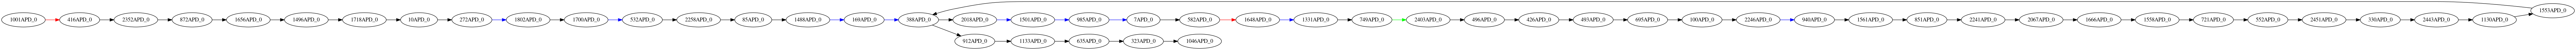

In [174]:
l = [('1001APD_0', '416APD_0', 3941.8076789237093, 13) ,
('100APD_0', '2246APD_0', 18596.376045441084, 11) ,
('10APD_0', '272APD_0', 1223.0781723398004, 14) ,
('1133APD_0', '635APD_0', 1383.428961829964, 17) ,
('1331APD_0', '749APD_0', 2000.4306127618484, 7) ,
('1418APD_0', '532APD_0', 2859.5, 1) ,
('1488APD_0', '169APD_0', 1422.6, 4) ,
('1496APD_0', '1718APD_0', 1291.75, 7) ,
('1501APD_0', '985APD_0', 635.5227077552963, 4) ,
('1558APD_0', '721APD_0', 3123.8990146450947, 17) ,
('1561APD_0', '851APD_0', 8286.264394725917, 15) ,
('1656APD_0', '1496APD_0', 1125.125, 7) ,
('1666APD_0', '1558APD_0', 4739.718253357601, 15) ,
('169APD_0', '388APD_0', 795.601787190874, 4) ,
('1700APD_0', '1418APD_0', 1099.793627727598, 3) ,
('1700APD_0', '532APD_0', 3941.4, 4) ,
('1718APD_0', '10APD_0', 2394.25, 7) ,
('1802APD_0', '1700APD_0', 479.7242107185324, 6) ,
('2018APD_0', '1501APD_0', 468.7869988621058, 4) ,
('2067APD_0', '1666APD_0', 1897.8713504189097, 17) ,
('2241APD_0', '2067APD_0', 1040.4732127712434, 16) ,
('2246APD_0', '940APD_0', 4942.265987150107, 4) ,
('2258APD_0', '85APD_0', 332.66088922727386, 7) ,
('2352APD_0', '872APD_0', 1143.0, 5) ,
('2403APD_0', '496APD_0', 577.0555246497047, 5) ,
('2451APD_0', '330APD_0', 1414.220940098523, 19) ,
('272APD_0', '1700APD_0', 2857.3333333333335, 5) ,
('272APD_0', '1802APD_0', 2373.4, 4) ,
('330APD_0', '272APD_0', 10231.0, -100) ,
('297APD_0', '1331APD_0', 4709.0, 1) ,
('323APD_0', '1046APD_0', 8231.666901604402, 16) ,
('635APD_0', '323APD_0', 6280.918650705924, 18) ,
('388APD_0', '2018APD_0', 2408.9376013336137, 5) ,
('388APD_0', '912APD_0', 2510.1518818443255, 19) ,
('416APD_0', '2352APD_0', 3873.8780013604205, 5) ,
('426APD_0', '493APD_0', 2240.4099245694624, 14) ,
('493APD_0', '695APD_0', 5999.916666666667, 11) ,
('496APD_0', '426APD_0', 1222.8708784649134, 10) ,
('532APD_0', '2258APD_0', 828.7237665162779, 7) ,
('532APD_0', '85APD_0', 1159.8000550101524, 12) ,
('552APD_0', '2451APD_0', 4198.528757945519, 15) ,
('582APD_0', '297APD_0', 1227.4158608992386, 5) ,
('695APD_0', '100APD_0', 2277.952130789894, 16) ,
('721APD_0', '552APD_0', 3286.32161332909, 15) ,
('749APD_0', '2403APD_0', 739.8547089649182, 3) ,
('7APD_0', '582APD_0', 1196.0141569550972, 6) ,
('851APD_0', '2241APD_0', 1588.8452096729143, 16) ,
('85APD_0', '1488APD_0', 2362.6673956303084, 7) ,
('85APD_0', '388APD_0', 4560.571428571428, 6) ,
('872APD_0', '1656APD_0', 699.9022763386432, 10) ,
('912APD_0', '1133APD_0', 2170.580503301033, 18) ,
('940APD_0', '1561APD_0', 544.1912472222558, 5) ,
('985APD_0', '7APD_0', 718.1305902637425, 4)]
k = {a:b for a,b,c,d in l}
len({a for a,b,c,d in l}), len({b for a,b,c,d in l}), len(l)
G = nx.MultiDiGraph()
for a,b,c,d in l:
    if d < 0:
        G.add_edge(a,b,c,color = 'red')
    elif d < 2:
        G.add_edge(a,b,c,color = 'orange')
    elif d < 3:
        G.add_edge(a,b,c,color = 'yellow')
    elif d < 4:
        G.add_edge(a,b,c,color = 'green')
    elif d < 5:
        G.add_edge(a,b,c,color = 'blue')
    else:
        G.add_edge(a,b,c)
    

pydot = nx.nx_pydot.to_pydot(G)
pydot.set_rankdir('LR')

pydot.write_png('t.png')
display(Image(filename='t.png'))

In [ ]:

('544APD_0', '1449APD_0', 516.3094614694, 17, 'I') 21.918671170344325
('1449APD_0', '2301APD_0', 543.5770494926411, 16, 'I') 21.918671170344325
('2301APD_0', '432APD_0', 2299.0, 1, 'I') 21.918671170344325
('432APD_0', '428APD_0', 285.56092084145143, 15, 'I') 21.918671170344325
('428APD_0', '1818APD_0', 741.39040569013, 15, 'I') 21.918671170344325
('1818APD_0', '544APD_0', 580.0951798897848, 16, 'I') 21.918671170344325

In [213]:
def foo(data):
    for e in data[:100]:
        if e[0] != e[1]:
            ilp_pfadverkürzung(data, e)

In [214]:
cP.run('foo(data4)')

Optimize a model with 43 rows, 614 columns and 2442 nonzeros
Variable types: 0 continuous, 614 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Found heuristic solution: objective -2.0000000
Presolve removed 1 rows and 81 columns
Presolve time: 0.07s
Presolved: 42 rows, 533 columns, 2092 nonzeros
Variable types: 0 continuous, 533 integer (131 binary)

Root relaxation: objective 2.028633e+02, 42 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  202.86334    0    3   -2.00000  202.86334      -     -    0s
H    0     0                     202.0000000  202.86334  0.43%     -    0s

Explored 1 nodes (42 simplex iterations) in 0.11 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 202 -2 

Optimal solu

Optimize a model with 64 rows, 1121 columns and 4468 nonzeros
Variable types: 0 continuous, 1121 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective -2.0000000
Presolve removed 4 rows and 31 columns
Presolve time: 0.04s
Presolved: 60 rows, 1090 columns, 4308 nonzeros
Variable types: 0 continuous, 1090 integer (222 binary)

Root relaxation: objective 5.740515e+02, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  574.05154    0    5   -2.00000  574.05154      -     -    0s
H    0     0                     564.0000000  574.05154  1.78%     -    0s
     0     0  572.33620    0    6  564.00000  572.33620  1.48%     -    0s
     0     0  572.33620    0    3  564.00000  572.33620  1.48%    

Optimize a model with 17 rows, 107 columns and 418 nonzeros
Variable types: 0 continuous, 107 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 14.0000000
Presolve removed 9 rows and 87 columns
Presolve time: 0.00s
Presolved: 8 rows, 20 columns, 74 nonzeros
Variable types: 0 continuous, 20 integer (17 binary)

Root relaxation: objective 4.117530e+01, 6 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   41.17530    0    2   14.00000   41.17530   194%     -    0s
H    0     0                      40.0000000   41.17530  2.94%     -    0s
     0     0 infeasible    0        40.00000   40.00000  0.00%     -    0s

Explored 1 nodes (6 simplex iterations) in 0.04 seconds
Thread count was 4 (o

Optimize a model with 51 rows, 768 columns and 3060 nonzeros
Variable types: 0 continuous, 768 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 3.0000000
Presolve removed 1 rows and 44 columns
Presolve time: 0.03s
Presolved: 50 rows, 724 columns, 2856 nonzeros
Variable types: 0 continuous, 724 integer (118 binary)

Root relaxation: objective 2.968942e+02, 49 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  296.89420    0    2    3.00000  296.89420  9796%     -    0s
H    0     0                     286.0000000  296.89420  3.81%     -    0s
     0     0     cutoff    0       286.00000  286.00000  0.00%     -    0s

Cutting planes:
  Gomory: 1

Explored 1 nodes (51 simplex iterations) 


     0     0  133.66928    0    3   11.00000  133.66928  1115%     -    0s
H    0     0                     132.0000000  133.66928  1.26%     -    0s
     0     0 infeasible    0       132.00000  132.00000  0.00%     -    0s

Explored 1 nodes (33 simplex iterations) in 0.13 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 132 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.320000000000e+02, best bound 1.320000000000e+02, gap 0.0000%
('1001APD_0', '416APD_0', 3941.8076789237093, 13) ,
('10APD_0', '272APD_0', 1223.0781723398004, 14) ,
('1488APD_0', '169APD_0', 1422.6, 4) ,
('1496APD_0', '1718APD_0', 1291.75, 7) ,
('1501APD_0', '985APD_0', 635.5227077552963, 4) ,
('1656APD_0', '1496APD_0', 1125.125, 7) ,
('169APD_0', '388APD_0', 795.601787190874, 4) ,
('1700APD_0', '532APD_0', 3941.4, 4) ,
('1718APD_0', '10APD_0', 2394.25, 7) ,
('1802APD_0', '1700APD_0', 479.7242107185324, 6) ,
('2018APD_0', '1501APD_0', 468.7869988621058, 4) ,
('2258APD_0', '85


Optimal solution found (tolerance 1.00e-04)
Best objective 7.800000000000e+01, best bound 7.800000000000e+01, gap 0.0000%
('1001APD_0', '416APD_0', 3941.8076789237093, 13) ,
('10APD_0', '272APD_0', 1223.0781723398004, 14) ,
('1496APD_0', '1718APD_0', 1291.75, 7) ,
('1656APD_0', '1496APD_0', 1125.125, 7) ,
('1718APD_0', '10APD_0', 2394.25, 7) ,
('1802APD_0', '1700APD_0', 479.7242107185324, 6) ,
('2352APD_0', '872APD_0', 1143.0, 5) ,
('272APD_0', '1802APD_0', 2373.4, 4) ,
('416APD_0', '2352APD_0', 3873.8780013604205, 5) ,
('872APD_0', '1656APD_0', 699.9022763386432, 10) ,
18545.9153396811
18545.9153396811
Optimize a model with 19 rows, 120 columns and 470 nonzeros
Variable types: 0 continuous, 120 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective 14.0000000
Presolve removed 9 rows and 89 columns
Presolve time: 0.00s
Presolve

Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+04]
Found heuristic solution: objective -2.0000000
Presolve removed 2 rows and 44 columns
Presolve time: 0.00s
Presolved: 9 rows, 24 columns, 88 nonzeros
Variable types: 0 continuous, 24 integer (17 binary)

Root relaxation: cutoff, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0     cutoff    0        -2.00000   -2.00000  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.04 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: -2 

Optimal solution found (tolerance 1.00e-04)
Best objective -2.000000000000e+00, best bound -2.000000000000e+00, gap 0.0000%
('2207APD_0', '1001APD_0', 11131.0, -2) ,
11131.0
11131.0
Optimize a model with 9 rows, 64 columns and 24

     0     0   17.64044    0    3   -2.00000   17.64044   982%     -    0s
     0     0   17.64044    0    9   -2.00000   17.64044   982%     -    0s
     0     0   17.64044    0   10   -2.00000   17.64044   982%     -    0s
     0     0   17.35015    0   11   -2.00000   17.35015   968%     -    0s
     0     0   16.77106    0    9   -2.00000   16.77106   939%     -    0s
     0     0   16.55130    0   11   -2.00000   16.55130   928%     -    0s
     0     0   16.50627    0   12   -2.00000   16.50627   925%     -    0s
     0     0   16.43870    0   11   -2.00000   16.43870   922%     -    0s
     0     0   15.32238    0   12   -2.00000   15.32238   866%     -    0s
     0     0   15.28618    0   12   -2.00000   15.28618   864%     -    0s
     0     0   15.27942    0   12   -2.00000   15.27942   864%     -    0s
     0     0   15.20985    0   13   -2.00000   15.20985   860%     -    0s
     0     0   15.20005    0   14   -2.00000   15.20005   860%     -    0s
     0     0   15.20005  

     0     0     cutoff    0        89.00000   89.00000  0.00%     -    0s

Cutting planes:
  MIR: 1

Explored 1 nodes (19 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 89 81 

Optimal solution found (tolerance 1.00e-04)
Best objective 8.900000000000e+01, best bound 8.900000000000e+01, gap 0.0000%
('1001APD_0', '416APD_0', 3941.8076789237093, 13) ,
('10APD_0', '272APD_0', 1223.0781723398004, 14) ,
('1496APD_0', '1718APD_0', 1291.75, 7) ,
('1656APD_0', '1496APD_0', 1125.125, 7) ,
('1700APD_0', '532APD_0', 3941.4, 4) ,
('1718APD_0', '10APD_0', 2394.25, 7) ,
('1802APD_0', '1700APD_0', 479.7242107185324, 6) ,
('2352APD_0', '872APD_0', 1143.0, 5) ,
('272APD_0', '1802APD_0', 2373.4, 4) ,
('416APD_0', '2352APD_0', 3873.8780013604205, 5) ,
('532APD_0', '2258APD_0', 828.7237665162779, 7) ,
('872APD_0', '1656APD_0', 699.9022763386432, 10) ,
23316.039106197382
23316.039106197382
Optimize a model with 67 rows, 1238 columns and 4936 nonzeros
V


     0     0  339.02314    0    2   -1.00000  339.02314      -     -    0s
H    0     0                     333.0000000  339.02314  1.81%     -    0s
     0     0     cutoff    0       333.00000  333.00000  0.00%     -    0s

Explored 1 nodes (54 simplex iterations) in 0.14 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 333 -1 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.330000000000e+02, best bound 3.330000000000e+02, gap 0.0000%
('1001APD_0', '416APD_0', 3416.0, -2) ,
('100APD_0', '2246APD_0', 18596.376045441084, 11) ,
('10APD_0', '272APD_0', 1223.0781723398004, 14) ,
('1331APD_0', '749APD_0', 2000.4306127618484, 7) ,
('1488APD_0', '169APD_0', 1422.6, 4) ,
('1496APD_0', '1718APD_0', 1291.75, 7) ,
('1501APD_0', '985APD_0', 635.5227077552963, 4) ,
('1558APD_0', '721APD_0', 3123.8990146450947, 17) ,
('1561APD_0', '851APD_0', 8286.264394725917, 15) ,
('1648APD_0', '1331APD_0', 677.4667689149961, 4) ,
('1656APD_0', '1496APD_0', 1125.125, 7) ,


Optimize a model with 64 rows, 1121 columns and 4468 nonzeros
Variable types: 0 continuous, 1121 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 4 rows and 20 columns
Presolve time: 0.05s
Presolved: 60 rows, 1101 columns, 4352 nonzeros
Variable types: 0 continuous, 1101 integer (222 binary)

Root relaxation: objective 6.128203e+02, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  612.82030    0    5          -  612.82030      -     -    0s
H    0     0                     107.0000000  612.82030   473%     -    0s
H    0     0                     255.0000000  612.82030   140%     -    0s
H    0     0                     599.0000000  612.82030  2.31%     -    0s
     0     0  607.55735    0    3  599

Optimize a model with 68 rows, 1131 columns and 4508 nonzeros
Variable types: 0 continuous, 1131 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective -6.0000000
Presolve removed 8 rows and 43 columns
Presolve time: 0.05s
Presolved: 60 rows, 1088 columns, 4300 nonzeros
Variable types: 0 continuous, 1088 integer (228 binary)

Root relaxation: objective 5.368789e+02, 57 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  536.87894    0    5   -6.00000  536.87894  9048%     -    0s
H    0     0                     527.0000000  536.87894  1.87%     -    0s
     0     0  535.39806    0    3  527.00000  535.39806  1.59%     -    0s
     0     0  535.39806    0    2  527.00000  535.39806  1.59%    

  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 4e+04]
Found heuristic solution: objective 1.0000000
Presolve removed 1 rows and 78 columns
Presolve time: 0.06s
Presolved: 39 rows, 470 columns, 1840 nonzeros
Variable types: 0 continuous, 470 integer (140 binary)

Root relaxation: objective 1.626841e+02, 39 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  162.68408    0    3    1.00000  162.68408      -     -    0s
H    0     0                     161.0000000  162.68408  1.05%     -    0s
     0     0 infeasible    0       161.00000  161.00000  0.00%     -    0s

Explored 1 nodes (39 simplex iterations) in 0.12 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 161 1 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.610000000000e+02, best bound 1.610000000000e+02, g

     0     0 infeasible    0       175.00000  175.00000  0.00%     -    0s

Explored 1 nodes (40 simplex iterations) in 0.11 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 175 23 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.750000000000e+02, best bound 1.750000000000e+02, gap 0.0000%
('1001APD_0', '416APD_0', 3941.8076789237093, 13) ,
('10APD_0', '272APD_0', 1223.0781723398004, 14) ,
('1331APD_0', '749APD_0', 2000.4306127618484, 7) ,
('1488APD_0', '169APD_0', 1422.6, 4) ,
('1496APD_0', '1718APD_0', 1291.75, 7) ,
('1501APD_0', '985APD_0', 635.5227077552963, 4) ,
('1648APD_0', '1331APD_0', 677.4667689149961, 4) ,
('1656APD_0', '1496APD_0', 1125.125, 7) ,
('169APD_0', '388APD_0', 795.601787190874, 4) ,
('1700APD_0', '532APD_0', 3941.4, 4) ,
('1718APD_0', '10APD_0', 2394.25, 7) ,
('1802APD_0', '1700APD_0', 479.7242107185324, 6) ,
('2018APD_0', '1501APD_0', 468.7869988621058, 4) ,
('2258APD_0', '85APD_0', 332.66088922727386, 7) ,
('2352APD_0', '8

Optimize a model with 60 rows, 995 columns and 3966 nonzeros
Variable types: 0 continuous, 995 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective 1.0000000
Presolve removed 23 rows and 611 columns
Presolve time: 0.08s
Presolved: 37 rows, 384 columns, 1496 nonzeros
Variable types: 0 continuous, 384 integer (128 binary)

Root relaxation: objective 1.397721e+02, 37 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  139.77215    0    2    1.00000  139.77215      -     -    0s
H    0     0                     139.0000000  139.77215  0.56%     -    0s

Explored 1 nodes (37 simplex iterations) in 0.11 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 139 1 

Optimal solu

Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+05]
Found heuristic solution: objective 39.0000000
Presolve removed 1 rows and 49 columns
Presolve time: 0.05s
Presolved: 51 rows, 748 columns, 2952 nonzeros
Variable types: 0 continuous, 748 integer (119 binary)

Root relaxation: objective 3.095324e+02, 53 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  309.53237    0    2   39.00000  309.53237   694%     -    0s
H    0     0                     303.0000000  309.53237  2.16%     -    0s
     0     0     cutoff    0       303.00000  303.00000  0.00%     -    0s

Explored 1 nodes (53 simplex iterations) in 0.12 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 303 39 

Optimal solution found (tolerance 1.00e-04)
Best ob

H    0     0                     187.0000000  234.23237  25.3%     -    0s
H    0     0                     222.0000000  234.23237  5.51%     -    0s
     0     0  227.68461    0    6  222.00000  227.68461  2.56%     -    0s
H    0     1                     226.0000000  227.68461  0.75%     -    0s

Cutting planes:
  Gomory: 1

Explored 1 nodes (50 simplex iterations) in 0.13 seconds
Thread count was 4 (of 4 available processors)

Solution count 4: 226 222 187 -1 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.260000000000e+02, best bound 2.260000000000e+02, gap 0.0000%
('1001APD_0', '416APD_0', 3416.0, -2) ,
('100APD_0', '2246APD_0', 18596.376045441084, 11) ,
('10APD_0', '272APD_0', 1223.0781723398004, 14) ,
('1331APD_0', '749APD_0', 2000.4306127618484, 7) ,
('1488APD_0', '169APD_0', 1422.6, 4) ,
('1496APD_0', '1718APD_0', 1291.75, 7) ,
('1501APD_0', '985APD_0', 635.5227077552963, 4) ,
('1561APD_0', '851APD_0', 8286.264394725917, 15) ,
('1656APD_0', '1496APD_0', 1125.12

     0     0   34.58612    0    6   29.00000   34.58612  19.3%     -    0s
     0     0   34.41888    0    6   29.00000   34.41888  18.7%     -    0s
     0     0   34.17671    0   10   29.00000   34.17671  17.9%     -    0s
     0     0   34.14241    0   10   29.00000   34.14241  17.7%     -    0s
     0     0   33.55617    0    8   29.00000   33.55617  15.7%     -    0s
     0     0   33.46126    0    8   29.00000   33.46126  15.4%     -    0s
     0     0   33.39269    0    8   29.00000   33.39269  15.1%     -    0s
     0     0   33.38187    0   10   29.00000   33.38187  15.1%     -    0s
     0     0   33.20104    0    6   29.00000   33.20104  14.5%     -    0s
     0     0   33.02690    0   10   29.00000   33.02690  13.9%     -    0s
     0     0   33.00944    0   10   29.00000   33.00944  13.8%     -    0s
     0     0   31.26339    0    7   29.00000   31.26339  7.80%     -    0s
     0     0   31.26339    0    7   29.00000   31.26339  7.80%     -    0s

Cutting planes:
  Gomory

Optimize a model with 18 rows, 118 columns and 472 nonzeros
Variable types: 0 continuous, 118 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective 11.0000000
Presolve removed 1 rows and 9 columns
Presolve time: 0.01s
Presolved: 17 rows, 109 columns, 432 nonzeros
Variable types: 0 continuous, 109 integer (73 binary)

Root relaxation: objective 1.940000e+02, 16 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     194.0000000  194.00000  0.00%     -    0s

Explored 0 nodes (16 simplex iterations) in 0.05 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 194 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.940000000000e+02, best bound 1

Optimize a model with 25 rows, 255 columns and 1018 nonzeros
Variable types: 0 continuous, 255 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 1 rows and 2 columns
Presolve time: 0.02s
Presolved: 24 rows, 253 columns, 1004 nonzeros
Variable types: 0 continuous, 253 integer (134 binary)
Found heuristic solution: objective 29.0000000

Root relaxation: objective 2.990000e+02, 24 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     299.0000000  299.00000  0.00%     -    0s

Explored 0 nodes (24 simplex iterations) in 0.06 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 299 29 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.990000000000e+02, best boun

Optimize a model with 38 rows, 559 columns and 2232 nonzeros
Variable types: 0 continuous, 559 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 9e+04]
Found heuristic solution: objective 5.0000000
Presolve removed 3 rows and 8 columns
Presolve time: 0.04s
Presolved: 35 rows, 551 columns, 2190 nonzeros
Variable types: 0 continuous, 551 integer (200 binary)

Root relaxation: objective 3.840000e+02, 33 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     384.0000000  384.00000  0.00%     -    0s

Explored 0 nodes (33 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 384 5 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.840000000000e+02, best bound 

Optimize a model with 11 rows, 30 columns and 120 nonzeros
Variable types: 0 continuous, 30 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 11.0000000
Presolve removed 1 rows and 2 columns
Presolve time: 0.00s
Presolved: 10 rows, 28 columns, 110 nonzeros
Variable types: 0 continuous, 28 integer (27 binary)

Root relaxation: objective 1.170000e+02, 8 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     117.0000000  117.00000  0.00%     -    0s

Explored 0 nodes (8 simplex iterations) in 0.03 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 117 11 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.170000000000e+02, best bound 1.17000

Optimize a model with 30 rows, 376 columns and 1502 nonzeros
Variable types: 0 continuous, 376 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 2e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 5e+04]
Presolve removed 1 rows and 2 columns
Presolve time: 0.03s
Presolved: 29 rows, 374 columns, 1484 nonzeros
Variable types: 0 continuous, 374 integer (190 binary)
Found heuristic solution: objective 27.0000000
Found heuristic solution: objective 35.0000000

Root relaxation: objective 3.430000e+02, 28 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     343.0000000  343.00000  0.00%     -    0s

Explored 0 nodes (28 simplex iterations) in 0.07 seconds
Thread count was 4 (of 4 available processors)

Solution count 3: 343 35 27 

Optimal solution found (tolerance 1.00


Explored 0 nodes (31 simplex iterations) in 0.10 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 370 2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.700000000000e+02, best bound 3.700000000000e+02, gap 0.0000%
('1002APD_0', '1195APD_0', 1781.0507608926919, 17) ,
('1003APD_0', '964APD_0', 738.8856964236371, 17) ,
('1035APD_0', '975APD_0', 1140.268705216926, 13) ,
('1195APD_0', '2039APD_0', 6450.644706779529, 22) ,
('1223APD_0', '1823APD_0', 3252.319769076626, 13) ,
('1406APD_0', '1880APD_0', 2719.159471456152, 11) ,
('1415APD_0', '817APD_0', 3133.308626299703, 9) ,
('1417APD_0', '755APD_0', 885.5482114847326, 15) ,
('1440APD_0', '1406APD_0', 1294.4512173566507, 12) ,
('1473APD_0', '1003APD_0', 1208.3837432604334, 18) ,
('1491APD_0', '2159APD_0', 1841.2786205357825, 13) ,
('1689APD_0', '1417APD_0', 2319.232448273729, 14) ,
('1823APD_0', '2286APD_0', 1688.5638068337232, 14) ,
('1880APD_0', '859APD_0', 2973.670831290167, 10) ,
('1883APD_0', '1440

In [192]:
[('1001APD_0', '1001APD_0', 28483.0, -2), ('2207APD_0', '1001APD_0', 13480.857142857143, 6), ('2207APD_0', '1001APD_0', 11131.0, -2), ('1001APD_0', '2207APD_0', 14764.0, -2), ('1001APD_0', '2207APD_0', 17713.0, -2), ('2232APD_0', '1001APD_0', 19197.0, -2), ('2232APD_0', '1001APD_0', 9517.42857142857, 6), ('2232APD_0', '1001APD_0', 8371.0, -2), ('1001APD_0', '2232APD_0', 9294.0, -2), ('1001APD_0', '2232APD_0', 20623.0, -2), ('416APD_0', '1001APD_0', 29242.0, -2), ('416APD_0', '1001APD_0', 785.0, -2), ('1001APD_0', '416APD_0', 3416.0, -2), ('1001APD_0', '416APD_0', 3941.8076789237093, 13), ('1001APD_0', '416APD_0', 4619.0, -2), ('1001APD_0', '416APD_0', 31616.0, -2), ('868APD_0', '1001APD_0', 24659.0, -2), ('868APD_0', '1001APD_0', 5484.847399667711, 15), ('1001APD_0', '868APD_0', 3847.0, -2), ('1001APD_0', '868APD_0', 24128.0, -2), ('1298APD_0', '1001APD_0', 10115.75, 3), ('1298APD_0', '2232APD_0', 607.2692633636426, 6), ('1298APD_0', '416APD_0', 14086.333333333334, 2), ('1298APD_0', '868APD_0', 4647.4, 4), ('2012APD_0', '1001APD_0', 10566.0, 1), ('2012APD_0', '1298APD_0', 438.6452319074034, 4), ('2012APD_0', '2232APD_0', 1050.0, 2), ('2012APD_0', '416APD_0', 14495.0, 1), ('2012APD_0', '868APD_0', 5101.0, 1), ('2090APD_0', '1298APD_0', 678.405738646083, -2), ('2207APD_0', '1298APD_0', 3299.3333333333335, 5), ('2207APD_0', '2012APD_0', 2853.6484093511344, 4), ('2207APD_0', '2090APD_0', 2597.019114452162, -2), ('2207APD_0', '2207APD_0', 2950.0, -2), ('2232APD_0', '2207APD_0', 8427.0, -2), ('2232APD_0', '2207APD_0', 5478.0, -2), ('2207APD_0', '2232APD_0', 3271.0, -2), ('2207APD_0', '2232APD_0', 3907.3, 9), ('2207APD_0', '2232APD_0', 5860.0, -2), ('2207APD_0', '2302APD_0', 2454.9532004241155, -2), ('416APD_0', '2207APD_0', 18472.0, -2), ('416APD_0', '2207APD_0', 15523.0, -2), ('2207APD_0', '416APD_0', 14264.0, -2), ('2207APD_0', '416APD_0', 17299.0, 5), ('868APD_0', '2207APD_0', 13889.0, -2), ('868APD_0', '2207APD_0', 10940.0, -2), ('2207APD_0', '868APD_0', 6776.0, -2), ('2207APD_0', '868APD_0', 7951.111111111111, 8), ('2207APD_0', '868APD_0', 9365.0, -2), ('2232APD_0', '2232APD_0', 11337.0, -2), ('416APD_0', '2232APD_0', 21382.0, -2), ('416APD_0', '2232APD_0', 10053.0, -2), ('2232APD_0', '416APD_0', 11504.0, -2), ('2232APD_0', '416APD_0', 13482.0, 4), ('2232APD_0', '416APD_0', 22330.0, -2), ('868APD_0', '2232APD_0', 16799.0, -2), ('868APD_0', '2232APD_0', 5470.0, -2), ('2232APD_0', '868APD_0', 4046.1794042609567, 12), ('2232APD_0', '868APD_0', 14842.0, -2), ('2302APD_0', '2012APD_0', 407.53047129622905, 1), ('416APD_0', '416APD_0', 32375.0, -2), ('868APD_0', '416APD_0', 27792.0, -2), ('868APD_0', '416APD_0', 10095.0, -2), ('868APD_0', '416APD_0', 9420.7, 9), ('868APD_0', '416APD_0', 8577.0, -2), ('416APD_0', '868APD_0', 4606.0, -2), ('416APD_0', '868APD_0', 24887.0, -2), ('868APD_0', '868APD_0', 20304.0, -2)]

[('1001APD_0', '1001APD_0', 28483.0, -2),
 ('2207APD_0', '1001APD_0', 13480.857142857143, 6),
 ('2207APD_0', '1001APD_0', 11131.0, -2),
 ('1001APD_0', '2207APD_0', 14764.0, -2),
 ('1001APD_0', '2207APD_0', 17713.0, -2),
 ('2232APD_0', '1001APD_0', 19197.0, -2),
 ('2232APD_0', '1001APD_0', 9517.42857142857, 6),
 ('2232APD_0', '1001APD_0', 8371.0, -2),
 ('1001APD_0', '2232APD_0', 9294.0, -2),
 ('1001APD_0', '2232APD_0', 20623.0, -2),
 ('416APD_0', '1001APD_0', 29242.0, -2),
 ('416APD_0', '1001APD_0', 785.0, -2),
 ('1001APD_0', '416APD_0', 3416.0, -2),
 ('1001APD_0', '416APD_0', 3941.8076789237093, 13),
 ('1001APD_0', '416APD_0', 4619.0, -2),
 ('1001APD_0', '416APD_0', 31616.0, -2),
 ('868APD_0', '1001APD_0', 24659.0, -2),
 ('868APD_0', '1001APD_0', 5484.847399667711, 15),
 ('1001APD_0', '868APD_0', 3847.0, -2),
 ('1001APD_0', '868APD_0', 24128.0, -2),
 ('1298APD_0', '1001APD_0', 10115.75, 3),
 ('1298APD_0', '2232APD_0', 607.2692633636426, 6),
 ('1298APD_0', '416APD_0', 14086.333333333334

In [99]:
a

'99APD_0'

In [73]:
model.update()

In [74]:
model

<gurobi.Model Continuous instance Unnamed: 0 constrs, 0 vars, Parameter changes: LogFile=gurobi.log, CSIdleTimeout=1800>

In [228]:
def f1(graph,aa,bb,dd, gg):
    graph.add_edge(aa,bb,(dd,gg), dist = dd)
def f2(graph,aa,bb,dd):
    na = set(nx.single_source_dijkstra_path(graph, aa, dd+500, 'dist'))
    nb = set(nx.single_source_dijkstra_path(graph.reverse(copy=False), bb, dd+500, 'dist'))
    return na & nb
def f3(graph, nodes):
    return graph.subgraph(nodes)
def f4(subgraph, nodes):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    edges = model.addVars(subgraph.edges(keys = True), vtype = GRB.BINARY)
    return model, edges
def f4_2(subgraph, nodes):
    model = Model()
    model.setParam(GRB.Param.LogToConsole, 0)
    edges = model.addVars(subgraph.edges(keys = True), vtype = GRB.INTEGER)
    return model, edges
        
def f5(model, subgraph, edges, aa, bb):
    for c in subgraph:
        if (c == aa or c == bb) and aa != bb:
            continue
        model.addConstr(sum(edges[c, b, k] for b, ks in subgraph.succ[c].items() for k in ks) == 1)
        model.addConstr(sum(edges[a, c, k] for a, ks in subgraph.pred[c].items() for k in ks) == 1)
    model.addConstr(sum(edges[aa, b, k] for b, ks in subgraph.succ[aa].items() for k in ks) == 1)
    model.addConstr(sum(edges[a, aa, k] for a, ks in subgraph.pred[aa].items() for k in ks) == 0)
    model.addConstr(sum(edges[bb, b, k] for b, ks in subgraph.succ[bb].items() for k in ks) == 0)
    model.addConstr(sum(edges[a, bb, k] for a, ks in subgraph.pred[bb].items() for k in ks) == 1)
def f5_2(model, subgraph, edges, aa, bb):
    for c in subgraph:
        ul = sum(edges[c, b, k] for b, ks in subgraph.succ[c].items() for k in ks)
        ur = sum(edges[a, c, k] for a, ks in subgraph.pred[c].items() for k in ks)
        if c == aa:
            ur += 1
        if c == bb:
            ur -= 1
        model.addConstr(ul == ur)
    if aa == bb:
        model.addConstr(sum(edges[aa, b, k] for b, ks in subgraph.succ[aa].items() for k in ks) >= 1)
        model.addConstr(sum(edges[a, bb, k] for a, ks in subgraph.pred[bb].items() for k in ks) >= 1)
        
def f6(model, edges, dd):
    model.addConstr(sum(d*v for (a,b,(d,g)),v in edges.items()) <= dd + 500) 
    model.addConstr(sum(d*v for (a,b,(d,g)),v in edges.items()) >= dd - 500) 

    model.setObjective(sum(g*v for (a,b,(d,g)),v in edges.items()), GRB.MAXIMIZE)
    
def f7(model):
    model.optimize()
    
def ilp_pfadverkürzung(dataX):
    dataX.sort(key = lambda x: x[2])
    graph = nx.MultiDiGraph()
    print(len(dataX))
    kannten_wege = {}
    i = -1
    j = 0
    for ee in dataX:
        i += 1
        if i%1000 == 0:
            print('i',i)
            print('j',j)
            print('e',len(graph.edges()))
            print()
        aa, bb, dd, gg = ee
        
        if not aa in graph or not bb in graph:
            f1(graph,aa,bb,dd,gg)
            continue
            
        nodes = f2(graph, aa, bb, dd) 
        
        subgraph = f3(graph, nodes)
        
        if (len(subgraph) < 3 or 
            not aa in subgraph or
            not nx.shortest_path_length(subgraph, aa, bb, 'dist') <= dd + 500):
            f1(graph,aa,bb,dd,gg)
            continue
            
        model, edges = f4(subgraph, nodes)

        f5(model, subgraph, edges, aa, bb)
        f6(model, edges, dd)
        f7(model)
        if not model.Status in {2,3,4}:
            print('status', model.Status)
            continue
            
        if model.Status in {3,4}:
            model, edges = f4_2(subgraph, nodes)
            f5_2(model, subgraph, edges, aa, bb)
            f6(model, edges, dd)
            f7(model)
        if model.Status in {3,4}:
            f1(graph,aa,bb,dd,gg)
            continue
        l = []
        for e,x in edges.items():
            if x.X != 0:
                l.append([e,x.X])
        kannten_wege[ee] = l
        j += 1
          #  break
   # print( sum(e[2]*x.X for e,x in edges.items() if x.X > 0) )
    #print( sum(e[2] for e,x in edges.items() if x.X > 0) )
    return kannten_wege, graph

In [ ]:

     8880    3.669    0.000   64.893    0.007 <ipython-input-347-26d4c0f4251d>:24(f6)
     8880   13.691    0.002   47.585    0.005 <ipython-input-347-26d4c0f4251d>:15(f5)
     8880    4.238    0.000   24.247    0.003 <ipython-input-347-26d4c0f4251d>:9(f4)
    10007    1.125    0.000   14.031    0.001 <ipython-input-347-26d4c0f4251d>:3(f2)
     8879    6.344    0.001    6.344    0.001 <ipython-input-347-26d4c0f4251d>:30(f7)
    10007    0.018    0.000    0.651    0.000 <ipython-input-347-26d4c0f4251d>:7(f3)
     1442    0.003    0.000    0.015    0.000 <ipython-input-347-26d4c0f4251d>:1(f1)
        
        
        
      816    0.153    0.000    0.592    0.001 <ipython-input-352-65cd8b648fa3>:24(f6)
      816    0.253    0.000    0.456    0.001 <ipython-input-352-65cd8b648fa3>:9(f4)
      816    0.157    0.000    0.431    0.001 <ipython-input-352-65cd8b648fa3>:15(f5)
      816    0.302    0.000    0.302    0.000 <ipython-input-352-65cd8b648fa3>:30(f7)
        

In [232]:
model = ilp_pfadverkürzung([(a,b,c,d) for a,b,c,d in data4 if d > 0])

18172
i 0
j 0
e 0

i 1000
j 140
e 860

i 2000
j 635
e 1365

i 3000
j 1374
e 1626

i 4000
j 2209
e 1791

i 5000
j 3119
e 1881

i 6000
j 4057
e 1943

i 7000
j 5026
e 1974

i 8000
j 5995
e 2005

i 9000
j 6975
e 2025

i 10000
j 7964
e 2036

i 11000
j 8956
e 2044

i 12000
j 9949
e 2051

i 13000
j 10940
e 2060

i 14000
j 11934
e 2066

i 15000
j 12929
e 2071

i 16000
j 13927
e 2073

i 17000
j 14922
e 2078

i 18000
j 15915
e 2085



In [78]:
model[0]

{('694APD_0',
  '462APD_0',
  338.2837823399922,
  -2): [[('491APD_0', '462APD_0', (169.41210525655586, 6)),
   1.0], [('694APD_0', '491APD_0', (172.972465737821, 1)), 1.0]],
 ('491APD_0',
  '413APD_0',
  366.36181707924504,
  1): [[('462APD_0', '413APD_0', (233.511869467201, -2)),
   1.0], [('491APD_0', '462APD_0', (169.41210525655586, 6)), 1.0]],
 ('2075APD_0',
  '413APD_0',
  379.34437793161595,
  1): [[('462APD_0', '413APD_0', (233.511869467201, -2)),
   1.0], [('2075APD_0', '462APD_0', (171.4299515644846, 9)), 1.0]],
 ('1768APD_0',
  '53APD_0',
  398.16126869274296,
  -2): [[('221APD_0', '53APD_0', (338.22230757973034, 9)),
   1.0], [('1768APD_0', '221APD_0', (357.450683928584, 1)), 1.0]],
 ('2401APD_0',
  '594APD_0',
  424.0,
  -2): [[('2133APD_0', '594APD_0', (92.0, -2)),
   1.0], [('2401APD_0', '2133APD_0', (348.1531941850853, 4)), 1.0]],
 ('164APD_0',
  '1004APD_0',
  430.7307682199745,
  1): [[('108APD_0', '1004APD_0', (272.66505196964533, 9)),
   1.0], [('164APD_0', '108APD_

In [80]:
len(model[0])

52786

In [84]:
k1 = 0
k2 = 0
for e,l in model[0].items():
    g = nx.Graph()
    for (a,b,k),m in l:
        g.add_edge(a,b)
    if not nx.is_connected(g):
        k1 += 1
    else:
        k2 += 1

In [85]:
k1,k2

(4448, 48338)

In [129]:
def f2(graph,aa,bb,dd):
    na = set(nx.single_source_dijkstra_path(graph, aa, dd+500, 'dist'))
    nb = set(nx.single_source_dijkstra_path(graph.reverse(copy=False), bb, dd+500, 'dist'))
    return graph.subgraph(na & nb) 

def pfadfinder_s(graph, aktuell, grenze, distanz, pfad):
    if distanz >= grenze:
        return [(pfad, distanz)]
    
    erg = []
    for nachfolger, distanz_liste in graph[aktuell].items():
        for d,_ in distanz_liste:
            erg += pfadfinder_s(graph, nachfolger, grenze, distanz + d, pfad + [nachfolger])
    return erg

def pfadfinder_e(graph, aktuell, grenze, gesammt_distanz, endknoten, distanz, pfad):
    erg = []
    if aktuell in endknoten:
        erg = [
            (x_pfad+pfad, x_dist + distanz)
            for x_pfad, x_dist in endknoten[aktuell]
            if gesammt_distanz - 500 <= x_dist + distanz <= gesammt_distanz + 500
        ]
    for vorgänger, distanz_liste in graph.pred[aktuell].items():
        for d,_ in distanz_liste:
            new_d = distanz + d
            if new_d <= grenze:
                erg += pfadfinder_e(graph, vorgänger, grenze, gesammt_distanz, endknoten, new_d, [vorgänger] + pfad)
    return erg
def pfadfinder(graph, start, ziel, distanz):
    grenze = (distanz + 500)/2
    erg_s = pfadfinder_s(graph, start, grenze, 0, [start])
    endknoten = {pfad[-1]: [] for pfad, dist in erg_s}
    for pfad, dist in erg_s:
        endknoten[pfad[-1]].append((pfad,dist))
    erg_e = pfadfinder_e(graph, ziel, grenze, distanz, endknoten, 0, [ziel])
    return  erg_e

In [236]:
def f2(graph,aa,bb,dd):
    dd += 500
    na = nx.single_source_dijkstra_path_length(graph, aa, dd, 'dist')
    nb = nx.single_source_dijkstra_path_length(graph.reverse(copy=False), bb, dd, 'dist')
    
    return  nx.MultiDiGraph(graph.subgraph(x for x in set(na)&set(nb) if na[x] + nb[x] <= dd)), nb

def pfadfinder_s(graph, entfernung, aktuell, ziel, grenze, distanz, pfad):
    erg = []
    if aktuell == ziel and distanz >= grenze - 1000:
        erg = [(pfad, distanz)]
    
    for nachfolger, distanz_liste in graph[aktuell].items():
        dd = distanz + entfernung[nachfolger]
        for d,_ in distanz_liste:
            if dd + d <= grenze:
                erg += pfadfinder_s(graph, 
                                    entfernung, 
                                    nachfolger, 
                                    ziel, 
                                    grenze, 
                                    distanz + d, 
                                    pfad + [nachfolger])
    return erg

def pfadfinder(graph, entfernung, start, ziel, distanz):
    erg_s = pfadfinder_s(graph, entfernung, start, ziel, distanz + 500, 0, [start])
    #endknoten = {pfad[-1]: [] for pfad, dist in erg_s}
    #for pfad, dist in erg_s:
    #    endknoten[pfad[-1]].append((pfad,dist))
    #erg_e = pfadfinder_e(graph, ziel, grenze, distanz, endknoten, 0, [ziel])
    return  erg_s

In [237]:
graph = model[1].copy()

In [238]:
data5[20000:20010]

NameError: name 'data5' is not defined

In [249]:
def foo():
    i = 0
    r = 0
    for a, b, d, g in data4[26000:26502]:
        if not a in graph or not b in graph:
            continue
        subgraph, entfernung = f2(graph, a, b, d)
        if not a in subgraph or not b in subgraph:
            continue
        erg = pfadfinder(subgraph, entfernung, a, b, d)
        i += 1
        if len(erg) == 30:
            return erg
        r = max(r,len(erg))
        if i % 500 == 0:
            print(i)
            print(len(erg))
    print(r)
            
            

In [250]:
erg = foo()

In [ ]:
'271APD_0','342APD_0',3970

'342APD_0','271APD_0', 670
'342APD_0','271APD_0',2513

'342APD_0', '342APD_0', 899

In [224]:
899+899+670
graph.remove_edge('342APD_0','271APD_0',(2413.0, -2))

NetworkXError: The edge 342APD_0-271APD_0 with key (2413.0, -2) is not in the graph.

In [227]:
graph.pred['342APD_0']

AdjacencyView({'2278APD_0': {(4016.2792386591177, 14): {'dist': 4016.2792386591177}}, '970APD_0': {(1653.0, -2): {'dist': 1653.0}}, '271APD_0': {(3970.0, 1): {'dist': 3970.0}}, '342APD_0': {(899.0, -2): {'dist': 899.0}}, '182APD_0': {(3989.0, -2): {'dist': 3989.0}}})

In [219]:
graph['342APD_0']
 271APD_0   670
 342APD_0   899
 501APD_0  2526
 132APD_0  2940
 132APD_0  3824
1948APD_0 24147

1769APD_0
 531APD_0

AdjacencyView({'271APD_0': {(670.0, -2): {'dist': 670.0}}, '342APD_0': {(899.0, -2): {'dist': 899.0}}, '501APD_0': {(2526.6666666666665, 2): {'dist': 2526.6666666666665}}, '132APD_0': {(2940.0, -2): {'dist': 2940.0}, (3824.0, 2): {'dist': 3824.0}}, '1948APD_0': {(24147.885657808474, 9): {'dist': 24147.885657808474}}})

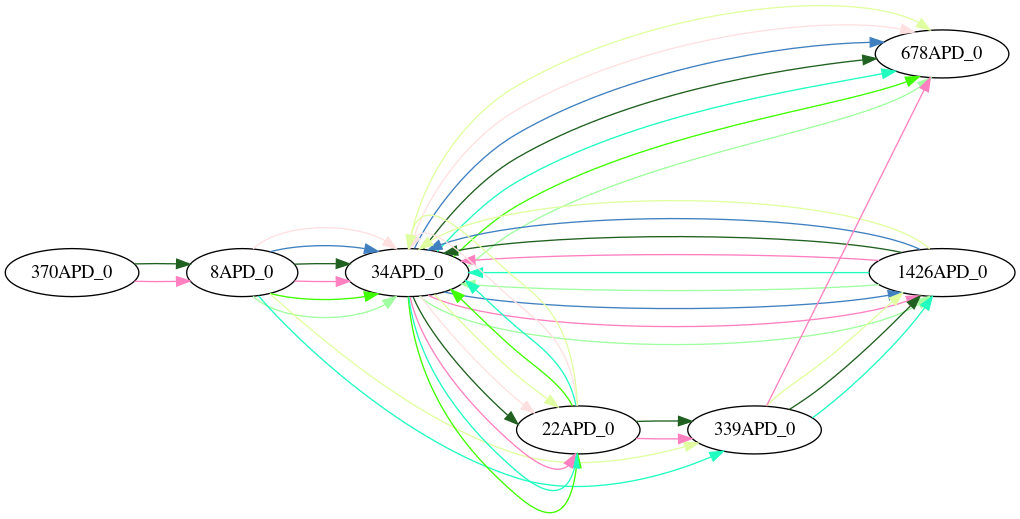

In [308]:
gg = nx.MultiDiGraph()
for i in range(0,30,4):
    color = '#%02x%02x%02x'%(min(np.random.randint(0,9)*32,255),min(np.random.randint(0,9)*32,255),min(np.random.randint(0,9)*32,255))
    for a,b in zip(erg[i][0][8:-4],erg[i][0][9:-3]):
        gg.add_edge(a,b,i,color= color)
    
pydot = nx.nx_pydot.to_pydot(gg)
pydot.set_rankdir('LR')

pydot.write_png('t.png')
display(Image(filename='t.png'))

In [259]:
np.random.randint(256)

61

In [272]:
8*8*8

512

In [282]:
for i in range(20):
    print('#%02x%02x%02x'%(min(np.random.randint(0,9)*32,255),min(np.random.randint(0,9)*32,255),min(np.random.randint(0,9)*32,255)))

#804040
#a02080
#00e0ff
#c08080
#60e080
#a04080
#406040
#a0c0ff
#006040
#40c0c0
#40a000
#e04060
#204000
#e00040
#8060c0
#00e0c0
#606000
#e00040
#ff6060
#2060c0


In [199]:
cP.run('foo()', sort = 1)

500
1
21854
         15817724 function calls (15173486 primitive calls) in 11.450 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
644738/500    4.230    0.000   10.463    0.021 <ipython-input-186-e22528a8042d>:8(pfadfinder_s)
  2217576    1.615    0.000    3.515    0.000 _collections_abc.py:742(__iter__)
  1535126    0.997    0.000    1.296    0.000 coreviews.py:80(__getitem__)
  2178890    0.730    0.000    1.158    0.000 coreviews.py:50(__iter__)
   655450    0.724    0.000    1.889    0.000 graph.py:448(__getitem__)
  2855764    0.528    0.000    0.528    0.000 coreviews.py:44(__init__)
   656450    0.473    0.000    0.618    0.000 multidigraph.py:310(adj)
   664188    0.452    0.000    0.588    0.000 coreviews.py:101(__getitem__)
  2179890    0.399    0.000    0.430    0.000 {built-in method builtins.iter}
   664974    0.374    0.000    0.499    0.000 _collections_abc.py:676(items)
   664974    0.125    0.000    0.125  

In [153]:
cP.run('foo()', sort = 1)

500
1
         4378001 function calls (4144665 primitive calls) in 5.418 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   100506    1.731    0.000    1.754    0.000 multidigraph.py:310(adj)
178118/500    0.553    0.000    2.986    0.006 <ipython-input-129-5afbc2cade64>:6(pfadfinder_s)
   479276    0.394    0.000    1.094    0.000 _collections_abc.py:742(__iter__)
    15520    0.374    0.000    0.374    0.000 <ipython-input-129-5afbc2cade64>:20(<listcomp>)
56218/500    0.343    0.000    1.140    0.002 <ipython-input-129-5afbc2cade64>:16(pfadfinder_e)
   289947    0.205    0.000    0.295    0.000 coreviews.py:80(__getitem__)
   429207    0.147    0.000    0.280    0.000 coreviews.py:50(__iter__)
     1000    0.137    0.000    0.299    0.000 weighted.py:755(_dijkstra_multisource)
   166694    0.124    0.000    0.184    0.000 coreviews.py:101(__getitem__)
   613365    0.117    0.000    0.117    0.000 coreviews.py:44(__init__)

In [128]:
cP.run('foo()', sort = 2)

500
1
         8464022 function calls (7878279 primitive calls) in 7.173 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    7.173    7.173 {built-in method builtins.exec}
        1    0.000    0.000    7.173    7.173 <string>:1(<module>)
        1    0.084    0.084    7.173    7.173 <ipython-input-127-62f52410bcc2>:1(foo)
      500    0.103    0.000    7.089    0.014 <ipython-input-117-058f34387df8>:25(pfadfinder)
235734/500    1.403    0.000    4.365    0.009 <ipython-input-117-058f34387df8>:11(pfadfinder_e)
351009/500    1.050    0.000    2.565    0.005 <ipython-input-117-058f34387df8>:1(pfadfinder_s)
  1178113    0.869    0.000    1.748    0.000 _collections_abc.py:742(__iter__)
    28162    1.155    0.000    1.155    0.000 <ipython-input-117-058f34387df8>:15(<listcomp>)
   776494    0.511    0.000    0.653    0.000 coreviews.py:80(__getitem__)
  1178113    0.376    0.000    0.604    0.000 c

In [ ]:
(['900APD_0', '766APD_0', '189APD_0', '1815APD_0'],
['1815APD_0', '2205APD_0', '58APD_0'], 

In [162]:
a = '900APD_0'
b = '58APD_0'
d = 22633.25
subgraph = f2(graph, a, b, d)
%timeit a = nx.shortest_path_length(subgraph, target = '58APD_0',weight = 'dist')
%timeit b = nx.single_source_dijkstra_path_length(subgraph.reverse(copy = False), '58APD_0',weight = 'dist')

subgraph = nx.MultiDiGraph(subgraph)
%timeit a = nx.shortest_path_length(subgraph, target = '58APD_0',weight = 'dist')
%timeit b = nx.single_source_dijkstra_path_length(subgraph.reverse(copy = False), '58APD_0',weight = 'dist')

180 µs ± 544 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
185 µs ± 473 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
36.5 µs ± 71.4 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
40.9 µs ± 111 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [164]:
nx.shortest_path_length(subgraph, target = '58APD_0',weight = 'dist')

{'58APD_0': 0,
 '2205APD_0': 5413.587712835594,
 '1815APD_0': 7578.682201006981,
 '189APD_0': 21290.945851642395,
 '766APD_0': 22123.17936597613,
 '900APD_0': 22966.125544873208}

In [96]:
def foo(h):
    e = []
    for i in range(5):
        e += h
    return e
def foo2(h):
    return [x for i in range(5) for x in h]

In [98]:
foo(h) == foo2(h)

True

In [ ]:

    erg = []
    for nachfolger, distanz_liste in graph[aktuell].items():
        for d in distanz_liste:
            erg += pfadfinder_s(graph, nachfolger, grenze, distanz+d, pfad + [nachfolger])